In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from ast import literal_eval
from collections import Counter
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities, matutils
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.stem.porter import PorterStemmer

### Prep Data

In [2]:
medium = pd.read_csv('medium_dataset.csv')

In [3]:
medium.columns

Index(['codeBlock', 'codeBlockCount', 'collectionId', 'createdDatetime',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'latestPublishedDatetime', 'linksCount', 'postId', 'readingTime',
       'recommends', 'responsesCreatedCount', 'socialRecommendsCount',
       'subTitle', 'text', 'title', 'totalClapCount', 'updatedDatetime', 'url',
       'wordCount', 'publicationdescription', 'publicationfollowerCount',
       'publicationname', 'publicationtags', 'author', 'bio', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'allTags'],
      dtype='object')

In [6]:
# The allTags column needs to be converted to type list. By default pandas will read the lists in as strings.
def convert_tags(tags):
    try:
        tags = literal_eval(tags)
        return tags
    except:
        return tags

medium['allTags'] = medium['allTags'].apply(convert_tags)

In [7]:
# Define a function to remove links from text
# Then remove non-alphanumeric characters, punctuation, and make lower case

def clean_text(text):
    # Remove links
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','', text)
    # Remove non-alphanumerics
    text = re.sub('\w*\d\w*', ' ', text)
    # Remove punctuation and lowercase
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    return text

medium['text'] = medium['text'].apply(clean_text)

In [8]:
medium.loc[0,'text']

'private business  government and blockchain  a major private it company implements blockchain  artificial intelligence  and internet of things to optimize and improve high technology workflow  the representatives of a major state structure from the same country like this experiment so much they decide to use it in their work and conclude an agreement with the it giant  this is an ideal example of interaction between private business and the state regarding blockchain  don’t you think  what is even better is that this story is real  in south korea a local customs office has signed the respective partnership agreement with samsung  i believe that the near term development of blockchain will be built on just such examples of cooperation  in a world where all the best technological decisions are copied at supersonic speed  one cannot remain behind the trends for long  that’s why i’m confident that blockchain and other crypto technologies will soon be adopted around the world  in the   cen

In [9]:
medium.loc[0,'allTags']

['Blockchain', 'Samsung', 'It']

### Simple Analysis

In [14]:
# Appears that our text and tags are looking good
# Lets create a single list of tags to represent topics that people are writing about
tag_list = []

for tags in medium['allTags']:
    if type(tags) == list:
        for tag in tags:
            tag_list.append(tag)
    

In [20]:
# Total number of tags applied
len(tag_list)

257650

In [22]:
# Total number of articles
medium.shape[0]

64417

In [23]:
# Average tags per article
len(tag_list)/medium.shape[0]

3.999720570656814

In [24]:
# Top 10 most popular tags in this dataset
pd.DataFrame(data = tag_list, columns = ['tags'])['tags'].value_counts().head(10)

Artificial Intelligence    32824
Machine Learning           27382
Data Science               16689
Deep Learning               6194
Technology                  6163
Blockchain                  4800
Python                      3075
Big Data                    2670
Tech                        2599
Chatbots                    2515
Name: tags, dtype: int64

In [27]:
# Frequency at which popular tags appear in the dataset
pd.DataFrame(data = tag_list, columns = ['tags'])['tags'].value_counts().head(10)/medium.shape[0]

Artificial Intelligence    0.509555
Machine Learning           0.425074
Data Science               0.259078
Deep Learning              0.096155
Technology                 0.095674
Blockchain                 0.074514
Python                     0.047736
Big Data                   0.041449
Tech                       0.040346
Chatbots                   0.039042
Name: tags, dtype: float64

In [34]:
# Dataset covers articles over an 8 year span from 2010 to 2018
print("Latest Published Date: " + str(medium['firstPublishedDatetime'].max()))
print("Earliest Published Date: " + str(medium['firstPublishedDatetime'].min()))

Latest Published Date: 2018-09-30 23:52:12
Earliest Published Date: 2010-10-27 07:00:00


In [37]:
# Towards Data Science is the most prolific publication in the dataset
medium['publicationname'].value_counts().head(10)

Towards Data Science                                3715
Hacker Noon                                         1185
Becoming Human: Artificial Intelligence Magazine     732
Data Driven Investor                                 637
Chatbots Life                                        461
SyncedReview                                         366
Chatbots Magazine                                    342
The Startup                                          310
DEEPAERODRONES                                       273
Good Audience                                        258
Name: publicationname, dtype: int64

In [39]:
medium['author'].value_counts().head(10)

Synced                  377
DEEP AERO DRONES        279
Yves Mulkers            182
C Gavilanes             163
Jae Duk Seo             158
WELTARE Strategies      140
TWiML & AI              134
Michael K. Spencer      124
Corsair's Publishing    121
Vantagepoint ai         113
Name: author, dtype: int64

In [53]:
test = Counter(medium.loc[0, 'text'].split(' '))
test.most_common(5)

[('', 20), ('the', 11), ('and', 6), ('a', 6), ('blockchain', 5)]

In [57]:
# Run a word count to determine most common words in corpus
# These words will likely need to be added to the stopwords list
# Don't count words that are allready in the default stopwords list

def update_counter(text):
    '''
    Function to update a word counter for corpus of documents
    '''
    word_list = []
    for word in text.split(' '):
        if word not in STOPWORDS:
            word_list.append(word)
    word_counter.update(word_list)

word_counter = Counter()

medium['text'].apply(update_counter)

In [62]:
print(word_counter.most_common(100))

[('', 9268338), ('data', 405551), ('ai', 223239), ('learning', 195515), ('—', 189145), ('time', 128504), ('machine', 126912), ('like', 126808), ('use', 115446), ('new', 111253), ('model', 108896), ('intelligence', 84933), ('people', 82011), ('need', 81119), ('it’s', 80934), ('human', 79753), ('technology', 75069), ('”', 74216), ('work', 72607), ('way', 71261), ('artificial', 68172), ('based', 65169), ('different', 62642), ('information', 62467), ('world', 62111), ('business', 58426), ('example', 58218), ('deep', 56145), ('training', 55299), ('set', 54501), ('network', 53781), ('science', 53150), ('want', 52164), ('better', 51989), ('help', 51391), ('know', 51230), ('future', 49531), ('image', 48455), ('process', 48144), ('value', 48000), ('number', 46962), ('good', 46569), ('learn', 46234), ('neural', 46179), ('models', 45635), ('create', 45014), ('think', 43510), ('companies', 43006), ('don’t', 42986), ('problem', 42941), ('best', 42668), ('google', 42010), ('real', 41909), ('code', 4

### Remove Stopwords and Stem

In [10]:
# Need custom stopword list to remove extremely common words and uninformative words
# List is based on word counter

stop_list = STOPWORDS.union(set(['data', 'ai', 'learning', 'time', 'machine', 'like', 'use', 'new', 'intelligence', 'need', "it's", 'way',
                                 'artificial', 'based', 'want', 'know', 'learn', "don't", 'things', 'lot', "let's", 'model', 'input',
                                 'output', 'train', 'training', 'trained', 'it', 'we', 'don', 'you', 'ce', 'hasn', 'sa', 'do', 'som',
                                 'can']))

In [11]:
# Remove stopwords before stemming
def remove_stopwords(text):
    clean_text = []
    for word in text.split(' '):
        if word not in stop_list and (len(word) > 2):
            clean_text.append(word)
    return ' '.join(clean_text)

# medium['processedText'] = medium['text'].apply(remove_stopwords)

In [12]:
# Apply stemmer to processedText
stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

# medium['processedText'] = medium['processedText'].apply(stem_text)

In [15]:
# Text processing takes a long time so lets save this to a csv file.
# Only include title and processed text. Can merge later if needed.

# processed_text = medium[['title', 'processedText']]
# processed_text.to_csv('processed_text.csv')

In [23]:
processed_text = pd.read_csv('processed_text.csv', engine = 'python')
medium.merge(processed_text, on = 'title')

In [24]:
# Remove articles that have less than 25 claps
medium = medium[medium['totalClapCount'] >= 25]
medium.reset_index(drop = True, inplace = True)

### LSA with Count-Vectorizer

In [59]:
vectorizer = CountVectorizer(stop_words = stop_list, ngram_range = (1,1))
doc_word = vectorizer.fit_transform(medium['processedText'])
doc_word.shape

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  sorted(inconsistent))


(24331, 122181)

In [60]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
sum(lsa.explained_variance_ratio_)

0.18551683177319656

In [61]:
def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
    count = 0
    for ix, topic in enumerate(model.components_):
        if count == no_top_topics:
            break
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", (ix + 1))
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        count += 1

In [62]:
display_topics(lsa, vectorizer.get_feature_names(), 15, 5)


Topic  1
work, imag, network, valu, differ, gener, set, human, creat, exampl, function, algorithm, featur, predict, process

Topic  2
technolog, human, compani, develop, peopl, busi, product, user, world, market, custom, year, servic, univers, design

Topic  3
imag, network, neural, layer, deep, technolog, convolut, univers, human, develop, detect, gener, research, cnn, architectur

Topic  4
user, imag, post, articl, recommend, read, contain, link, medium, product, minut, got, follow, tag, total

Topic  5
word, vector, text, languag, sentenc, embed, document, human, context, univers, gener, topic, similar, sequenc, neural


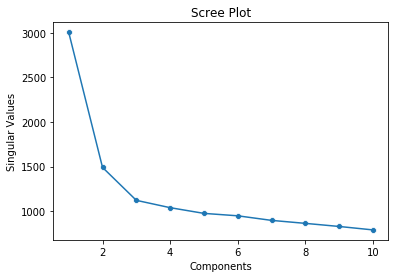

In [63]:
# Make scree plot to find "elbow" in the curve
def scree_plot(model):
    sns.scatterplot(range(1,len(model.singular_values_) + 1), model.singular_values_)
    sns.lineplot(range(1, len(model.singular_values_) + 1), model.singular_values_)
    plt.ylabel('Singular Values')
    plt.xlabel('Components')
    plt.title('Scree Plot');

scree_plot(lsa)

In [64]:
column_names = ['title', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
doc_topic_df = pd.DataFrame(data = doc_topic)
doc_topic_df = pd.concat([medium['title'], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.to_csv('doc_topics/cv_lsa.csv')

In [65]:
doc_topic_df.head(10)

,title,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,"Private Business, Government and Blockchain",2.572103,2.187154,0.502166,-0.873994,-0.421615,-0.439496,0.684973,-0.213432,0.492300,0.906722
1,Can a robot love us better than another human ...,2.138676,1.941139,0.855390,-1.372673,0.534460,-0.496961,-2.615383,-0.067351,0.998855,-1.583857
2,"2017 Big Data, AI and IOT Use Cases",21.507346,6.918177,2.540492,-1.441746,-2.156544,-0.580637,0.893407,-0.107590,1.444580,6.561033
3,The Meta Model and Meta Meta-Model of Deep Lea...,17.596733,-7.913611,8.052864,-8.077486,2.819822,-3.767872,2.580095,7.798444,-4.198906,0.045903
4,Don’t trust “Do you trust this computer”,6.086537,1.791294,-0.512620,-0.800008,0.321344,-0.454184,-1.771749,-0.432767,-0.213229,-0.495882
5,AI based UI Development (AI-UI),23.336545,-3.233887,11.677909,4.893821,6.821510,-1.320850,0.839488,-4.740960,-3.268678,-2.310289
6,Can Technology Replace Record Companies?,10.269063,6.771809,0.331749,0.256963,-1.687690,-0.959218,-0.094428,1.028008,1.170641,3.113925
7,Five tech trends that shaped 2017,9.214466,4.473292,0.069785,-0.176298,-1.365136,-0.861852,0.027734,-0.747685,2.421319,3.476138
8,Vectorized implementation of back-propagation,13.481701,-9.371026,-4.874353,-1.712090,0.257150,-0.179776,3.535885,4.069254,-0.647734,0.607250
9,Building Smarter Businesses With Cognitive Ser...,24.122838,12.162627,3.499068,1.292071,0.531736,-7.154521,6.610337,-1.755313,1.508663,-6.280733


### LSA topic modeling with TF-IDF

In [67]:
# Now use TF-IDF on stemmed words
vectorizer = TfidfVectorizer(stop_words = stop_list, ngram_range = (1,1))
doc_word = vectorizer.fit_transform(medium['processedText'])
doc_word.shape

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  sorted(inconsistent))


(24331, 122181)

In [68]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
sum(lsa.explained_variance_ratio_)

0.060918372439343865

In [69]:
display_topics(lsa, vectorizer.get_feature_names(), 15, 5)


Topic  1
human, network, imag, technolog, work, user, algorithm, predict, peopl, compani, product, busi, deep, custom, develop

Topic  2
imag, layer, network, neural, function, dataset, featur, weight, convolut, vector, valu, gradient, deep, predict, paramet

Topic  3
chatbot, bot, user, custom, convers, app, messag, messeng, chat, servic, text, word, voic, assist, interact

Topic  4
imag, network, layer, neural, human, convolut, deep, chatbot, robot, neuron, technolog, cnn, brain, gan, architectur

Topic  5
imag, blockchain, tensorflow, file, python, project, token, api, cloud, instal, platform, app, code, team, googl


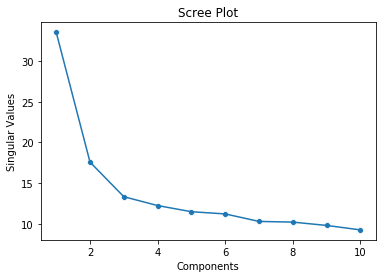

In [70]:
scree_plot(lsa)

In [71]:
column_names = ['title', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
doc_topic_df = pd.DataFrame(data = doc_topic)
doc_topic_df = pd.concat([medium['title'], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.to_csv('doc_topics/tfidf_lsa.csv')

In [72]:
doc_topic_df.head(10)

,title,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,"Private Business, Government and Blockchain",0.178884,-0.121232,-0.069383,0.038513,0.085572,0.202256,0.003007,0.082129,-0.066861,-0.120637
1,Can a robot love us better than another human ...,0.127685,-0.081833,-0.073055,0.078810,-0.135534,-0.101230,-0.053367,0.000688,-0.087831,-0.017994
2,"2017 Big Data, AI and IOT Use Cases",0.303092,-0.048748,-0.060017,0.006398,0.010995,0.047787,-0.009899,-0.023107,0.015369,0.004864
3,The Meta Model and Meta Meta-Model of Deep Lea...,0.159462,0.119690,-0.017373,0.099864,-0.021567,-0.013477,0.096826,0.032550,-0.002159,0.038268
4,Don’t trust “Do you trust this computer”,0.176201,-0.054761,-0.039563,-0.012132,-0.044707,-0.032058,-0.012744,0.006832,-0.002659,-0.028011
5,AI based UI Development (AI-UI),0.354908,0.130072,0.023945,0.150442,0.052031,-0.119153,-0.080988,0.090753,0.095866,-0.024011
6,Can Technology Replace Record Companies?,0.255896,-0.112751,-0.039948,-0.025354,0.016787,0.073536,0.029555,-0.051935,0.070180,0.029426
7,Five tech trends that shaped 2017,0.290928,-0.125446,-0.051235,0.023141,0.033080,0.113100,-0.042130,0.001659,-0.011924,-0.025267
8,Vectorized implementation of back-propagation,0.182779,0.216899,0.029648,-0.048771,-0.068699,0.128676,0.033490,0.088935,-0.036723,0.026918
9,Building Smarter Businesses With Cognitive Ser...,0.295806,-0.109444,0.053222,0.055372,0.011529,0.018186,-0.032056,0.003509,0.023319,0.090634


### NMF with Count-Vectorizer

In [73]:
vectorizer = CountVectorizer(stop_words = stop_list, ngram_range = (1,1))
doc_word = vectorizer.fit_transform(medium['processedText'])
doc_word.shape

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  sorted(inconsistent))


(24331, 122181)

In [74]:
nmf = NMF(10)
doc_topic = nmf.fit_transform(doc_word)

In [75]:
display_topics(nmf, vectorizer.get_feature_names(), 15, 10)


Topic  1
human, peopl, work, think, world, problem, robot, design, understand, algorithm, year, technolog, question, gener, game

Topic  2
valu, featur, predict, set, function, algorithm, variabl, number, test, mean, differ, point, exampl, result, distribut

Topic  3
imag, gener, detect, featur, object, dataset, convolut, layer, label, class, cnn, face, differ, classifi, pixel

Topic  4
post, articl, read, recommend, user, medium, link, total, got, minut, contain, tag, follow, imag, titl

Topic  5
word, vector, text, sentenc, embed, languag, document, gener, similar, context, exampl, process, topic, sequenc, mean

Topic  6
univers, introduct, scienc, technolog, institut, cours, universidad, state, school, econom, nation, école, research, health, program

Topic  7
compani, technolog, develop, busi, market, product, servic, blockchain, industri, team, provid, year, custom, platform, process

Topic  8
network, neural, layer, deep, function, weight, neuron, activ, convolut, gradient, comp

In [76]:
# Not as sure how to interpret NMF results. Discuss with Jonathan or Kelly.
# Are there equivalents to explained variance, singular value, scree plots.

In [77]:
column_names = ['title', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
doc_topic_df = pd.DataFrame(data = doc_topic)
doc_topic_df = pd.concat([medium['title'], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.to_csv('doc_topics/cv_nmf.csv')
doc_topic_df.head(10)

,title,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,"Private Business, Government and Blockchain",0.015594,0.002227,0.000000,0.000000,0.001319,0.004864,0.083326,0.000000,0.000000,0.000000
1,Can a robot love us better than another human ...,0.095583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"2017 Big Data, AI and IOT Use Cases",0.145723,0.121449,0.028608,0.112197,0.004935,0.017837,0.358794,0.107948,0.035020,0.000000
3,The Meta Model and Meta Meta-Model of Deep Lea...,0.139977,0.000000,0.042185,0.000000,0.038871,0.000150,0.000000,0.554729,0.159663,0.000000
4,Don’t trust “Do you trust this computer”,0.093893,0.030600,0.011863,0.000000,0.015931,0.000000,0.029034,0.000000,0.041544,0.022494
5,AI based UI Development (AI-UI),0.097077,0.000000,0.400526,0.027704,0.270826,0.003467,0.132260,0.143099,0.228447,0.119822
6,Can Technology Replace Record Companies?,0.092996,0.025965,0.000000,0.064833,0.000000,0.000000,0.224304,0.001412,0.000000,0.019968
7,Five tech trends that shaped 2017,0.057214,0.074104,0.000473,0.054316,0.003136,0.000000,0.196487,0.000000,0.000000,0.000000
8,Vectorized implementation of back-propagation,0.000000,0.258305,0.000000,0.036397,0.124820,0.000000,0.000000,0.212011,0.136786,0.000000
9,Building Smarter Businesses With Cognitive Ser...,0.195597,0.000000,0.035413,0.000000,0.050369,0.000000,0.322357,0.081957,0.112031,0.373466


In [78]:
np.sum(doc_topic, axis = 0)

array([2510.0265675 , 2563.63383   , 1500.19086337,  812.7778212 ,
       1248.27895796,  421.76359578, 2582.46726127, 1802.70446535,
       3088.41534925, 2007.59542634])

### NMF with TF-IDF

In [79]:
vectorizer = TfidfVectorizer(stop_words = stop_list, ngram_range = (1,1))
doc_word = vectorizer.fit_transform(medium['processedText'])
doc_word.shape

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  sorted(inconsistent))


(24331, 122181)

In [80]:
nmf = NMF(10)
doc_topic = nmf.fit_transform(doc_word)

In [81]:
display_topics(nmf, vectorizer.get_feature_names(), 15, 10)


Topic  1
human, robot, technolog, peopl, machin, world, futur, job, think, car, brain, autom, year, live, work

Topic  2
valu, predict, variabl, featur, regress, function, linear, algorithm, test, set, dataset, paramet, tree, gradient, error

Topic  3
chatbot, bot, convers, user, custom, messag, messeng, chat, interact, answer, question, intent, assist, servic, app

Topic  4
imag, network, layer, neural, convolut, deep, neuron, cnn, weight, function, architectur, loss, gener, gan, pixel

Topic  5
file, tensorflow, python, code, instal, imag, run, notebook, api, librari, creat, googl, dataset, gpu, app

Topic  6
blockchain, token, technolog, decentr, platform, contract, crypto, cryptocurr, secur, develop, transact, trade, market, bitcoin, network

Topic  7
scienc, scientist, cours, work, skill, team, project, job, peopl, engin, program, deep, start, statist, student

Topic  8
word, vector, text, sentenc, embed, languag, document, nlp, sentiment, corpu, sequenc, context, token, topic, m

In [82]:
column_names = ['title', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
doc_topic_df = pd.DataFrame(data = doc_topic)
doc_topic_df = pd.concat([medium['title'], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.to_csv('doc_topics/tfidf_nmf.csv')
doc_topic_df.head(10)

,title,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,"Private Business, Government and Blockchain",0.004515,0.000000,0.000000,0.000000,0.000000,0.104021,0.000000,0.000000,0.008685,0.004595
1,Can a robot love us better than another human ...,0.050545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"2017 Big Data, AI and IOT Use Cases",0.021488,0.016219,0.000000,0.011420,0.002707,0.017267,0.016503,0.000000,0.002314,0.037421
3,The Meta Model and Meta Meta-Model of Deep Lea...,0.005351,0.000000,0.000000,0.041374,0.002414,0.000000,0.009610,0.006702,0.017805,0.000000
4,Don’t trust “Do you trust this computer”,0.025134,0.005807,0.003594,0.000000,0.000982,0.004583,0.017190,0.004253,0.002540,0.003623
5,AI based UI Development (AI-UI),0.020127,0.000000,0.001837,0.053501,0.026424,0.000000,0.006968,0.058460,0.001900,0.018799
6,Can Technology Replace Record Companies?,0.009662,0.005330,0.000000,0.001099,0.000000,0.012183,0.026517,0.000000,0.001647,0.055374
7,Five tech trends that shaped 2017,0.023274,0.012993,0.002757,0.000073,0.000000,0.044093,0.001413,0.000000,0.000000,0.045074
8,Vectorized implementation of back-propagation,0.000000,0.047475,0.000000,0.023341,0.003549,0.007092,0.000000,0.034209,0.000000,0.000000
9,Building Smarter Businesses With Cognitive Ser...,0.019891,0.000000,0.012462,0.007718,0.008117,0.000000,0.000000,0.008527,0.008771,0.071517


In [83]:
np.sum(doc_topic, axis = 0)

array([276.76295807, 282.79221864, 146.2343023 , 224.22812591,
       273.38309709, 232.00681056, 315.46330193, 188.17044652,
       165.2776098 , 374.29759922])

### Use Coherence to Determine Optimal Number of Topics

In [84]:
tokenized_docs = medium['processedText'].apply(simple_preprocess)

# There are still some useless words that tend to get through the pre-processing steps.
# Mostly they are longer forms of useless words that become reduced by stemming or they are partial contractions.
# Clean this up.

def clean_tokens(tokenized_docs):
    '''
    Removes useless word tokens
    '''
    clean_tokenized_docs = []
    
    # Iterate through the documents
    for doc in tokenized_docs:
        clean_doc = []
        # Iterate through words of document
        for word in doc:
            # Remove words in stop_list
            if word not in stop_list:
                clean_doc.append(word)
      
        clean_tokenized_docs.append(clean_doc)
        
    return clean_tokenized_docs

tokenized_docs = clean_tokens(tokenized_docs)

In [87]:
dictionary = gensim.corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [88]:
def compute_coherence_values(dictionary, corpus, texts, limit = 21, start=4, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    num_topics_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.LdaMulticore(corpus = corpus, num_topics=num_topics, id2word=dictionary, passes=3, workers=3)
        num_topics_list.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return num_topics_list, coherence_values

In [89]:
num_topics, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_docs)

4
8
12
16
20


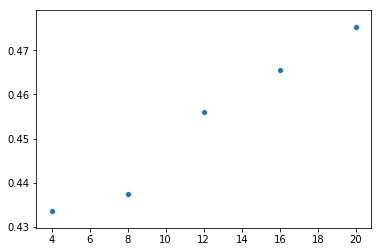

In [90]:
sns.scatterplot(num_topics, coherence_values)

In [127]:
# It seems that coherence is increasing linearly with number of topics
# Lets model up to 32 topics and see if this levels off

In [91]:
num_topics2, coherence_values2 = compute_coherence_values(dictionary, corpus, tokenized_docs, start = 24, limit = 33)

24
28
32


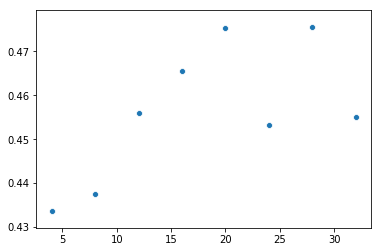

In [93]:
# There is very little difference in coherence across number of topics
# Just stick with 10
sns.scatterplot(num_topics + num_topics2, coherence_values + coherence_values2)

### LDA with Bag of Words
(BOW is the same as Count-Vectorizer)

In [94]:
# Use 10 passes to allow algorithm more time to converge
lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, passes=10, workers = 3)

In [95]:
lda.print_topics()

[(0,
  '0.017*"human" + 0.009*"technolog" + 0.007*"robot" + 0.007*"peopl" + 0.006*"world" + 0.005*"futur" + 0.004*"job" + 0.004*"autom" + 0.004*"algorithm" + 0.004*"car"'),
 (1,
  '0.027*"word" + 0.013*"text" + 0.010*"vector" + 0.008*"languag" + 0.007*"column" + 0.007*"dataset" + 0.007*"number" + 0.006*"document" + 0.006*"sentenc" + 0.006*"embed"'),
 (2,
  '0.046*"imag" + 0.018*"network" + 0.012*"layer" + 0.011*"deep" + 0.010*"detect" + 0.010*"tensorflow" + 0.009*"neural" + 0.009*"dataset" + 0.008*"object" + 0.008*"convolut"'),
 (3,
  '0.025*"user" + 0.015*"price" + 0.010*"recommend" + 0.009*"predict" + 0.009*"market" + 0.008*"bot" + 0.008*"product" + 0.007*"custom" + 0.007*"item" + 0.007*"trade"'),
 (4,
  '0.013*"code" + 0.011*"python" + 0.009*"run" + 0.008*"file" + 0.008*"project" + 0.007*"tool" + 0.007*"build" + 0.007*"scienc" + 0.006*"instal" + 0.005*"api"'),
 (5,
  '0.017*"valu" + 0.013*"function" + 0.012*"predict" + 0.012*"featur" + 0.008*"variabl" + 0.008*"number" + 0.008*"algor

In [96]:
from collections import defaultdict
# Initialize a dictionary to store results
doc_topic_df = defaultdict(list)

# List of column names to use later
column_names = ['title', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']

# Set of all topics
topics = set([0,1,2,3,4,5,6,7,8,9])

# Iterate through topic breakdown of document
for i, row in enumerate(lda[corpus]):
    
    # Initialize a set of topics included in document breakdown
    row_topics = []
    
    # Iterate through topics of document
    for topic in row:
        # Add topic to row_topics
        row_topics.append(topic[0])
        # Add topic strength to dictionary
        doc_topic_df[topic[0]].append(topic[1])
    
    # Make row topics a set then determine remaining topics
    # Set strength of remaining topics to 0
    row_topics = set(row_topics)
    remaining_topics = topics - row_topics
    
    for topic in remaining_topics:
        doc_topic_df[topic].append(0)
        
    if i % 10000 == 0:
        print(i)

doc_topic_df = pd.DataFrame(doc_topic_df)
doc_topic_df = pd.concat([medium['title'], doc_topic_df], axis = 1)
doc_topic_df.columns = column_names
doc_topic_df.head(10)
        

0
10000
20000


,title,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,"Private Business, Government and Blockchain",0.088077,0.137885,0.764824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Can a robot love us better than another human ...,0.483625,0.049657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.456994,0.000000
2,"2017 Big Data, AI and IOT Use Cases",0.357986,0.110071,0.242251,0.000000,0.020325,0.028912,0.020739,0.044757,0.090898,0.083925
3,The Meta Model and Meta Meta-Model of Deep Lea...,0.000000,0.000000,0.000000,0.000000,0.142398,0.000000,0.000000,0.000000,0.000000,0.855796
4,Don’t trust “Do you trust this computer”,0.587490,0.000000,0.000000,0.016114,0.000000,0.067756,0.000000,0.000000,0.326296,0.000000
5,AI based UI Development (AI-UI),0.021211,0.219609,0.000000,0.183950,0.292929,0.000000,0.000000,0.000000,0.056728,0.224719
6,Can Technology Replace Record Companies?,0.000000,0.105002,0.525038,0.000000,0.000000,0.000000,0.000000,0.053610,0.314649,0.000000
7,Five tech trends that shaped 2017,0.189707,0.088393,0.506725,0.000000,0.000000,0.047726,0.000000,0.032976,0.107698,0.025999
8,Vectorized implementation of back-propagation,0.000000,0.000000,0.040748,0.041655,0.048829,0.017402,0.000000,0.850056,0.000000,0.000000
9,Building Smarter Businesses With Cognitive Ser...,0.000000,0.649258,0.022504,0.000000,0.000000,0.000000,0.096855,0.000000,0.000000,0.230485


In [97]:
doc_topic_df.to_csv('doc_topics/cv_lda.csv')

In [98]:
np.sum(np.array(doc_topic_df.iloc[:,1:]), axis = 0)

array([3216.45191959, 2751.00371735, 3737.21949294, 1468.16746883,
       1858.12808506, 1096.8228712 , 2135.48176143, 2535.11751966,
       3644.33077487, 1804.44366737])

In [99]:
import pickle
with open('models/cv_lsa_10tp_10pa.pkl', 'wb') as file:
    pickle.dump(lsa, file)

### Visualize LDA results with pyLDAvis

In [135]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [136]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.128995 -0.098729       1        1  14.370337
7     -0.084354 -0.060934       2        1  14.033061
8     -0.163981  0.015852       3        1  12.574184
5      0.170585 -0.055670       4        1  12.170563
6     -0.123260  0.058543       5        1  10.562901
9      0.044327 -0.124784       6        1   8.735771
4      0.014622  0.116534       7        1   8.364697
2      0.135252 -0.008854       8        1   7.977193
1      0.149619  0.052893       9        1   6.563869
3     -0.013816  0.105149      10        1   4.647433, topic_info=     Category          Freq        Term         Total  loglift  logprob
294   Default  48230.000000        imag  48230.000000  30.0000  30.0000
941   Default  40230.000000        user  40230.000000  29.0000  29.0000
947   Default  26121.000000        word  26121.000000  28.0000  28.0000
375   Default  50048.000000     network  50048.000000  27.0000  27.0000
77    Default  45235.000000       human  45235.000000  26.0000  26.0000
376   Default  25812.000000      neural  25812.000000  25.0000  25.0000
18    Default  26815.000000      custom  26815.000000  24.0000  24.0000
204   Default  30117.000000        deep  30117.000000  23.0000  23.0000
1093  Default  15347.000000     chatbot  15347.000000  22.0000  22.0000
55    Default  39649.000000   technolog  39649.000000  21.0000  21.0000
341   Default  21893.000000      market  21893.000000  20.0000  20.0000
634   Default  21321.000000       layer  21321.000000  19.0000  19.0000
5     Default  13407.000000  blockchain  13407.000000  18.0000  18.0000
943   Default  41313.000000        valu  41313.000000  17.0000  17.0000
415   Default  10473.000000       price  10473.000000  16.0000  16.0000
11    Default  31481.000000     compani  31481.000000  15.0000  15.0000
1304  Default  13337.000000         bot  13337.000000  14.0000  14.0000
176   Default  29843.000000        code  29843.000000  13.0000  13.0000
1240  Default  23125.000000     dataset  23125.000000  12.0000  12.0000
413   Default  36586.000000     predict  36586.000000  11.0000  11.0000
508   Default  14054.000000        text  14054.000000  10.0000  10.0000
419   Default  33056.000000     product  33056.000000   9.0000   9.0000
2482  Default  16078.000000      python  16078.000000   8.0000   8.0000
267   Default  34947.000000    function  34947.000000   7.0000   7.0000
1291  Default  12150.000000      vector  12150.000000   6.0000   6.0000
253   Default  33315.000000      featur  33315.000000   5.0000   5.0000
8     Default  27046.000000        busi  27046.000000   4.0000   4.0000
697   Default   9879.000000  tensorflow   9879.000000   3.0000   3.0000
271   Default  14257.000000        game  14257.000000   2.0000   2.0000
1656  Default  12984.000000        file  12984.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1086  Topic10   1547.878662     bitcoin   3082.253906   2.3801  -5.8398
2252  Topic10   1022.995789   portfolio   1885.219238   2.4575  -6.2539
1304  Topic10   4494.267578         bot  13337.400391   1.9811  -4.7739
155   Topic10   1968.619019         buy   4670.252441   2.2050  -5.5993
2404  Topic10   1550.586670     purchas   3553.295898   2.2396  -5.8380
5397  Topic10    758.038757     anomali   1425.980591   2.4370  -6.5537
3236  Topic10   1429.884644      period   3638.098633   2.1350  -5.9191
1035  Topic10   2101.843506        sale   6526.950195   1.9357  -5.5339
341   Topic10   4538.554199      market  21893.906250   1.4953  -4.7641
1036  Topic10   1358.786255        sell   3566.105469   2.1040  -5.9701
1034  Topic10   2081.821533      return   7520.736328   1.7844  -5.5434
413   Topic10   4990.318848     predict  36586.230469   1.0767  -4.6692
773   Topic10   1506.384399        movi   4783.103027   1.9135  -5.8670
18    Topic10   3847.414307      custom  26815.480469   1.1273  -4.92